### Process for update_forecast.py

Steps:
1. Scrape new data
2. Process
3. Forecast
4. Output to SQLite

Outputs: 
1. MAE data of model (save only as csv? takes too long to run regularly) 
2. Get snapshots 
3. Prediction results mixed with regular forecast results


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


logging.getLogger().setLevel(logging.ERROR)
from sklearn.preprocessing import PolynomialFeatures

from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor

from sqlalchemy import create_engine
from sqlalchemy import(Table, Column, String, Integer, Boolean)
from sqlalchemy import MetaData, Table

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import os

from sklearn.utils import resample
import numpy as np

rcParams['figure.figsize'] = 9, 6

import glob

from sqlalchemy import create_engine
from datetime import datetime
time_of_search = datetime.now().date()

import datetime

In [4]:
# Connecting to Engine
engine = create_engine('sqlite:///nickel_database.sqlite')

connection = engine.connect()

# What's in the database already?
print(engine.table_names())


['2yr_test_preds_0', '2yr_test_preds_1', '2yr_test_preds_2', '2yr_test_preds_3', '2yr_test_preds_4', '2yr_train_preds_0', '2yr_train_preds_1', '2yr_train_preds_2', '2yr_train_preds_3', '2yr_train_preds_4', 'LME', 'forecasts_main', 'global_prod', 'inventory', 'test_preds_0', 'test_preds_1', 'test_preds_2', 'test_preds_3', 'test_preds_4', 'train_preds_0', 'train_preds_1', 'train_preds_2', 'train_preds_3', 'train_preds_4', 'upsampled_china', 'upsampled_china_consump']


In [5]:
# Original LME 

LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']

LME_futures = LME_futures.iloc[:, 1:]
#LME_futures = LME_futures[LME_futures.index.year>=2000]

LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)
LME = LME.resample('B').mean()
LME = LME.squeeze()


LME_shifted = LME.shift(-261).dropna()

LME.tail(45)

Unnamed: 1
2019-10-08    17555.0
2019-10-09    17740.0
2019-10-10    17725.0
2019-10-11    17990.0
2019-10-14    17395.0
2019-10-15    17030.0
2019-10-16    16995.0
2019-10-17    16320.0
2019-10-18    16450.0
2019-10-21    16190.0
2019-10-22    16015.0
2019-10-23    16390.0
2019-10-24    16945.0
2019-10-25    16880.0
2019-10-28    16675.0
2019-10-29    16670.0
2019-10-30    16890.0
2019-10-31    16830.0
2019-11-01    16745.0
2019-11-04    16585.0
2019-11-05    16230.0
2019-11-06    16380.0
2019-11-07    16300.0
2019-11-08    16180.0
2019-11-11    15720.0
2019-11-12    15490.0
2019-11-13    15520.0
2019-11-14    15350.0
2019-11-15    14980.0
2019-11-18    14750.0
2019-11-19    14470.0
2019-11-20    14305.0
2019-11-21    14405.0
2019-11-22    14375.0
2019-11-25    14560.0
2019-11-26    14365.0
2019-11-27    14435.0
2019-11-28    14060.0
2019-11-29    13805.0
2019-12-02    13620.0
2019-12-03    13595.0
2019-12-04    13240.0
2019-12-05    13160.0
2019-12-06    13415.0
2019-12-09    13195.0

### Read Data

In [6]:
#LME = pd.read_sql_query('SELECT * from LME;', connection)
#LME.index = pd.to_datetime(LME['index'])
#LME = LME.iloc[:,1:]
#LME = LME.resample('B').mean()
#LME = LME.squeeze()

#####

global_prod = pd.read_sql_query('SELECT * from global_prod;', connection)
global_prod.index = pd.to_datetime(global_prod['index'])
global_prod = global_prod.iloc[:,1:]

global_prod = global_prod.resample('B').mean()
global_prod = global_prod.squeeze()

#####

inventory = pd.read_sql_query('SELECT * from inventory;', connection)
inventory.index = pd.to_datetime(inventory['Unnamed: 1'])
inventory = inventory.iloc[:,1:]

inventory = inventory.resample('B').mean()
inventory = inventory.squeeze()

#####

upsampled_china = pd.read_sql_query('SELECT * from upsampled_china;', connection)
upsampled_china.index = pd.to_datetime(upsampled_china['index'])
upsampled_china = upsampled_china.iloc[:,1:]

upsampled_china = upsampled_china.resample('B').mean()


#####

upsampled_china_consump = pd.read_sql_query('SELECT * from upsampled_china_consump;', connection)
upsampled_china_consump.index = pd.to_datetime(upsampled_china_consump['index'])
upsampled_china_consump = upsampled_china_consump.iloc[:,1:]

upsampled_china_consump = upsampled_china_consump.resample('B').mean()






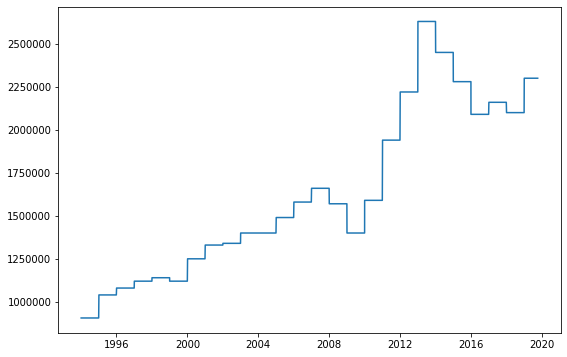

In [8]:
plt.plot(global_prod)

# Step 1 - Scrape New Nickel Data



# Step 2 - Preprocess Data


### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [7]:
def preprocess(series, window_setting):
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

    

In [8]:
'''Returns unscaled y values BUT MUST ASSIGN INDEX AFTER FUNCTION! '''
def unscale(series, original_tail, window_setting):
    unscaled = []
    for key, item in series.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))
        unscaled.append(unscaled_result)
        
    unscaled = pd.Series(unscaled)
    unscaled = unscaled
    return unscaled

LME_shifted = LME.shift(-261).dropna()


In [9]:
# Rolling Average from last 8 weeks
window_setting= 5*4
LME_stationary = preprocess(LME, window_setting)
inventory_stationary=preprocess(inventory, window_setting)
upsampled_stationary = preprocess(upsampled_china['GDP per capita growth (annual %)'], window_setting)
global_prod_stationary = preprocess(global_prod, window_setting)



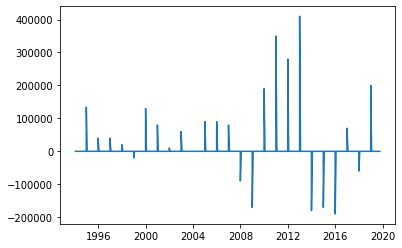

In [8]:
plt.plot(global_prod_stationary)

#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [94]:

# Rolling Average from last 8 weeks
window_setting= 5*4
LME_stationary = preprocess(LME, window_setting)
inventory_stationary=preprocess(inventory, window_setting)
upsampled_stationary = preprocess(upsampled_china['GDP per capita growth (annual %)'], window_setting)
global_prod_stationary = preprocess(global_prod, window_setting)


rcParams['figure.figsize'] = 9, 6

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'lag0'])
df.head()

# How many lag periods? - LAG DAYS
lag_length = 20

df['lag1'] = df.lag0.shift(periods=1*lag_length)
df['lag2'] = df.lag0.shift(periods=2*lag_length)
df['lag3'] = df.lag0.shift(periods=3*lag_length)
df['lag4'] = df.lag0.shift(periods=4*lag_length)
df['lag5'] = df.lag0.shift(periods=5*lag_length)

df['lag6'] = df.lag0.shift(periods=6*lag_length)
df['lag7'] = df.lag0.shift(periods=7*lag_length)
df['lag8'] = df.lag0.shift(periods=8*lag_length)
df['lag9'] = df.lag0.shift(periods=9*lag_length)
df['lag10'] = df.lag0.shift(periods=10*lag_length)

df['lag11'] = df.lag0.shift(periods=11*lag_length)
df['lag12'] = df.lag0.shift(periods=13*lag_length)
df['lag13'] = df.lag0.shift(periods=15*lag_length)
df['lag14'] = df.lag0.shift(periods=17*lag_length)
df['lag15'] = df.lag0.shift(periods=19*lag_length)
df['lag16'] = df.lag0.shift(periods=21*lag_length)
df['lag17'] = df.lag0.shift(periods=23*lag_length)
'''
df['lag18'] = df.lag0.shift(periods=26*lag_length)
df['lag19'] = df.lag0.shift(periods=29*lag_length)
df['lag20'] = df.lag0.shift(periods=32*lag_length)

df['lag21'] = df.lag0.shift(periods=35*lag_length)
df['lag22'] = df.lag0.shift(periods=38*lag_length)
'''

df.index = df['ds']
df = df.iloc[:, 1:]
# df['gdp'] = upsampled_stationary
# df['global_prod'] = global_prod_stationary
# df['week_of_year'] = df.index.weekofyear 
# df['day_of_month'] = df.index.day
# df['gdp_capita'] = upsampled_china['GDP per capita (current US$)']
# df['gdp_capita_growth'] = upsampled_china['GDP per capita growth (annual %)']

# df['consumption_exp'] = preprocess(upsampled_china_consump['Final consumption expenditure (current US$)'], window_setting)
# df['consumption_percent_gdp'] = preprocess(upsampled_china_consump['Final consumption expenditure (% of GDP)'], window_setting)



df['y'] = df['lag0'].shift(-261)
#df = df.dropna(subset=['global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17'])

df = df.dropna(subset=['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17'])


#df = df.dropna()

df.tail()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,y
ds,,,,,,,,,,,,,,,,,,,
2019-12-03,-1370.00,-670.75,-37.175,1464.325,1279.30,1518.9625,-8.7250,-15.575,-621.5375,-40.8125,295.575,685.450,-79.4375,394.900,-253.6625,-567.0375,176.150,234.850,NaN
2019-12-04,-1593.25,-454.50,176.475,1177.625,1252.80,1827.3125,151.1250,-92.075,-568.7125,-64.6875,348.925,839.975,27.0125,26.375,-824.9125,-232.2375,289.900,156.825,NaN
2019-12-05,-1516.25,-466.50,172.075,1280.175,1481.60,2105.4125,357.8000,-162.225,-611.2125,-245.9375,311.900,890.975,-319.1125,20.825,-310.1375,-235.2875,335.175,-183.875,NaN
2019-12-06,-1104.25,-515.25,458.475,843.025,1339.95,1839.0500,129.6625,310.750,-482.0125,-136.2625,429.275,995.450,-207.6375,-5.400,-149.1875,37.1125,-61.725,-165.200,NaN
2019-12-09,-1186.00,-884.75,-145.575,415.675,983.85,1281.9750,197.0875,311.075,-475.3625,-0.8625,459.625,1520.500,-296.0625,-50.175,-60.8375,-520.2125,-328.100,-189.350,NaN


# Step 3. Forecasting

### Splitting up Training/Testing by Day

- Train multiple models on 261*16=4176 days versus Tests of 261 AND 522 days (1 and 2 years)

How to normalize/standardize: 
https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

### GOAL: To run tests over last 10??? years to take a closer look at MAE's over different sliding windows -- To get a sense of the long term accuracy of the model - scenario evaluation

In [96]:
dates = df.index
#dates[dates<datetime.datetime(2002, 10, 2)][::5]

In [11]:
np.sqrt(261*15)

62.56996084384263

In [17]:
# Tester Run
import datetime

for item in dates[dates<datetime.datetime(2002, 10, 2)][::5]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    print(end_date_test)

2011-11-09 00:00:00
2011-11-16 00:00:00
2011-11-23 00:00:00
2011-11-30 00:00:00
2011-12-07 00:00:00
2011-12-14 00:00:00
2011-12-21 00:00:00
2011-12-28 00:00:00
2012-01-04 00:00:00
2012-01-11 00:00:00
2012-01-18 00:00:00
2012-01-25 00:00:00
2012-02-01 00:00:00
2012-02-08 00:00:00
2012-02-15 00:00:00
2012-02-22 00:00:00
2012-02-29 00:00:00
2012-03-07 00:00:00
2012-03-14 00:00:00
2012-03-21 00:00:00
2012-03-28 00:00:00
2012-04-04 00:00:00
2012-04-11 00:00:00
2012-04-18 00:00:00
2012-04-25 00:00:00
2012-05-02 00:00:00
2012-05-09 00:00:00
2012-05-16 00:00:00
2012-05-23 00:00:00
2012-05-30 00:00:00
2012-06-06 00:00:00
2012-06-13 00:00:00
2012-06-20 00:00:00
2012-06-27 00:00:00
2012-07-04 00:00:00
2012-07-11 00:00:00
2012-07-18 00:00:00
2012-07-25 00:00:00
2012-08-01 00:00:00
2012-08-08 00:00:00
2012-08-15 00:00:00
2012-08-22 00:00:00
2012-08-29 00:00:00
2012-09-05 00:00:00
2012-09-12 00:00:00
2012-09-19 00:00:00
2012-09-26 00:00:00
2012-10-03 00:00:00
2012-10-10 00:00:00
2012-10-17 00:00:00


In [111]:
# Building the Model! Training period. 

results = []
datelist = []
paramlist = []

for item in dates[dates<datetime.datetime(2002, 10, 2)]:
#for item in dates[dates<datetime.datetime(2003, 10, 2)][::5]:

    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    #!!! NOTE TRAINING is cumulative
    train = df.loc[:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    

    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                     'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    X_test = test[[ 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                   'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]

    
    y_train = train['y']
    y_test = test['y']

    '''
    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)
    
    scalerX = StandardScaler()
    X_train = scalerX.fit_transform(X_train)
    X_test = scalerX.transform(X_test)
    '''
    
    cv_results={}

    
    for K in range(0, 60, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
  
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)

    

2006-11-07 00:00:00 , Optimal K: 59 , MAE: 8937.899398304295
2006-11-08 00:00:00 , Optimal K: 59 , MAE: 9073.86766302963
2006-11-09 00:00:00 , Optimal K: 59 , MAE: 9243.509931251981
2006-11-10 00:00:00 , Optimal K: 59 , MAE: 9545.474477421172
2006-11-13 00:00:00 , Optimal K: 59 , MAE: 9796.985232420398
2006-11-14 00:00:00 , Optimal K: 59 , MAE: 10024.257610567816
2006-11-15 00:00:00 , Optimal K: 59 , MAE: 10210.876951991018
2006-11-16 00:00:00 , Optimal K: 57 , MAE: 10196.540516937825
2006-11-17 00:00:00 , Optimal K: 59 , MAE: 10114.560220257974
2006-11-20 00:00:00 , Optimal K: 59 , MAE: 9900.90704520136
2006-11-21 00:00:00 , Optimal K: 59 , MAE: 9704.173835837133
2006-11-22 00:00:00 , Optimal K: 59 , MAE: 9474.141959441133
2006-11-23 00:00:00 , Optimal K: 7 , MAE: 8864.051501461247
2006-11-24 00:00:00 , Optimal K: 5 , MAE: 8355.49377871742
2006-11-27 00:00:00 , Optimal K: 5 , MAE: 7869.561719393858
2006-11-28 00:00:00 , Optimal K: 5 , MAE: 7616.144269016088
2006-11-29 00:00:00 , Optim

2007-05-15 00:00:00 , Optimal K: 29 , MAE: 13509.465863782832
2007-05-16 00:00:00 , Optimal K: 29 , MAE: 13313.593968778972
2007-05-17 00:00:00 , Optimal K: 29 , MAE: 13204.975848890019
2007-05-18 00:00:00 , Optimal K: 29 , MAE: 13119.528072755265
2007-05-21 00:00:00 , Optimal K: 29 , MAE: 13051.120563278655
2007-05-22 00:00:00 , Optimal K: 29 , MAE: 12995.849017154564
2007-05-23 00:00:00 , Optimal K: 29 , MAE: 12803.07332920164
2007-05-24 00:00:00 , Optimal K: 29 , MAE: 12391.748456120644
2007-05-25 00:00:00 , Optimal K: 1 , MAE: 11768.573380086998
2007-05-28 00:00:00 , Optimal K: 29 , MAE: 11748.717114670348
2007-05-29 00:00:00 , Optimal K: 29 , MAE: 11423.200504910974
2007-05-30 00:00:00 , Optimal K: 29 , MAE: 11071.063536926371
2007-05-31 00:00:00 , Optimal K: 1 , MAE: 10708.915735472963
2007-06-01 00:00:00 , Optimal K: 29 , MAE: 10448.514205184338
2007-06-04 00:00:00 , Optimal K: 29 , MAE: 10224.582117645905
2007-06-05 00:00:00 , Optimal K: 29 , MAE: 10050.514445002527
2007-06-06 

2007-11-20 00:00:00 , Optimal K: 29 , MAE: 1480.9903296738476
2007-11-21 00:00:00 , Optimal K: 29 , MAE: 1417.754237918223
2007-11-22 00:00:00 , Optimal K: 19 , MAE: 1273.3211181240574
2007-11-23 00:00:00 , Optimal K: 15 , MAE: 1171.5427788828085
2007-11-26 00:00:00 , Optimal K: 15 , MAE: 1146.8121327402923
2007-11-27 00:00:00 , Optimal K: 15 , MAE: 1111.10394037848
2007-11-28 00:00:00 , Optimal K: 15 , MAE: 1106.3127167229666
2007-11-29 00:00:00 , Optimal K: 15 , MAE: 1090.898644689016
2007-11-30 00:00:00 , Optimal K: 15 , MAE: 1084.3490253622485
2007-12-03 00:00:00 , Optimal K: 15 , MAE: 1083.8570581057143
2007-12-04 00:00:00 , Optimal K: 13 , MAE: 1103.7801446901738
2007-12-05 00:00:00 , Optimal K: 13 , MAE: 1119.2895267395172
2007-12-06 00:00:00 , Optimal K: 13 , MAE: 1142.7710767340172
2007-12-07 00:00:00 , Optimal K: 13 , MAE: 1178.0523068479342
2007-12-10 00:00:00 , Optimal K: 13 , MAE: 1205.4918656705058
2007-12-11 00:00:00 , Optimal K: 13 , MAE: 1249.0554414844257
2007-12-12 0

2008-05-23 00:00:00 , Optimal K: 23 , MAE: 1751.1564931204891
2008-05-26 00:00:00 , Optimal K: 23 , MAE: 1732.073952500153
2008-05-27 00:00:00 , Optimal K: 23 , MAE: 1720.4212625293135
2008-05-28 00:00:00 , Optimal K: 23 , MAE: 1730.3961764392632
2008-05-29 00:00:00 , Optimal K: 25 , MAE: 1730.5480190967303
2008-05-30 00:00:00 , Optimal K: 29 , MAE: 1728.2192900836058
2008-06-02 00:00:00 , Optimal K: 29 , MAE: 1704.3151738059319
2008-06-03 00:00:00 , Optimal K: 29 , MAE: 1700.4774085754962
2008-06-04 00:00:00 , Optimal K: 33 , MAE: 1702.3265769147124
2008-06-05 00:00:00 , Optimal K: 33 , MAE: 1686.6051091947425
2008-06-06 00:00:00 , Optimal K: 33 , MAE: 1691.5522084666154
2008-06-09 00:00:00 , Optimal K: 37 , MAE: 1696.6741642570296
2008-06-10 00:00:00 , Optimal K: 39 , MAE: 1692.9830128779445
2008-06-11 00:00:00 , Optimal K: 39 , MAE: 1692.7914741747793
2008-06-12 00:00:00 , Optimal K: 43 , MAE: 1683.2003026947018
2008-06-13 00:00:00 , Optimal K: 45 , MAE: 1676.8587621420527
2008-06-1

2008-11-26 00:00:00 , Optimal K: 41 , MAE: 1697.4832409378948
2008-11-27 00:00:00 , Optimal K: 39 , MAE: 1667.0149576123426
2008-11-28 00:00:00 , Optimal K: 33 , MAE: 1657.7534760073847
2008-12-01 00:00:00 , Optimal K: 31 , MAE: 1647.830882520909
2008-12-02 00:00:00 , Optimal K: 17 , MAE: 1649.1536215725523
2008-12-03 00:00:00 , Optimal K: 15 , MAE: 1651.7203916322364
2008-12-04 00:00:00 , Optimal K: 15 , MAE: 1666.7675463928276
2008-12-05 00:00:00 , Optimal K: 15 , MAE: 1708.1564809304887
2008-12-08 00:00:00 , Optimal K: 15 , MAE: 1746.996537172534
2008-12-09 00:00:00 , Optimal K: 15 , MAE: 1809.4253473135464
2008-12-10 00:00:00 , Optimal K: 11 , MAE: 1818.0719331474602
2008-12-11 00:00:00 , Optimal K: 9 , MAE: 1871.7357869411046
2008-12-12 00:00:00 , Optimal K: 9 , MAE: 1854.6876036171986
2008-12-15 00:00:00 , Optimal K: 9 , MAE: 1833.327276114852
2008-12-16 00:00:00 , Optimal K: 11 , MAE: 1821.3267094889873
2008-12-17 00:00:00 , Optimal K: 11 , MAE: 1801.8583829108286
2008-12-18 00:

2009-06-02 00:00:00 , Optimal K: 33 , MAE: 2578.31459006685
2009-06-03 00:00:00 , Optimal K: 33 , MAE: 2677.333930278602
2009-06-04 00:00:00 , Optimal K: 33 , MAE: 2865.8764310236706
2009-06-05 00:00:00 , Optimal K: 33 , MAE: 3074.3598492510114
2009-06-08 00:00:00 , Optimal K: 33 , MAE: 3295.363619329215
2009-06-09 00:00:00 , Optimal K: 33 , MAE: 3483.310340184546
2009-06-10 00:00:00 , Optimal K: 45 , MAE: 3620.7967941038673
2009-06-11 00:00:00 , Optimal K: 51 , MAE: 3773.0017693443715
2009-06-12 00:00:00 , Optimal K: 53 , MAE: 3854.8017735099647
2009-06-15 00:00:00 , Optimal K: 53 , MAE: 3853.8438855132886
2009-06-16 00:00:00 , Optimal K: 53 , MAE: 3863.4151543488197
2009-06-17 00:00:00 , Optimal K: 53 , MAE: 3881.6370364417894
2009-06-18 00:00:00 , Optimal K: 51 , MAE: 3919.557394916172
2009-06-19 00:00:00 , Optimal K: 55 , MAE: 3943.907503747052
2009-06-22 00:00:00 , Optimal K: 55 , MAE: 3982.866038815134
2009-06-23 00:00:00 , Optimal K: 55 , MAE: 4018.73023514253
2009-06-24 00:00:0

2009-12-08 00:00:00 , Optimal K: 11 , MAE: 2332.6730203812867
2009-12-09 00:00:00 , Optimal K: 9 , MAE: 2282.067967254345
2009-12-10 00:00:00 , Optimal K: 7 , MAE: 2257.751932817908
2009-12-11 00:00:00 , Optimal K: 7 , MAE: 2211.8873493474107
2009-12-14 00:00:00 , Optimal K: 7 , MAE: 2176.2718351240046
2009-12-15 00:00:00 , Optimal K: 7 , MAE: 2165.889911571645
2009-12-16 00:00:00 , Optimal K: 7 , MAE: 2165.568612120419
2009-12-17 00:00:00 , Optimal K: 7 , MAE: 2173.077646756278
2009-12-18 00:00:00 , Optimal K: 7 , MAE: 2177.088245160849
2009-12-21 00:00:00 , Optimal K: 7 , MAE: 2189.0218677786
2009-12-22 00:00:00 , Optimal K: 7 , MAE: 2177.0428759577785
2009-12-23 00:00:00 , Optimal K: 5 , MAE: 2196.3480112828975
2009-12-24 00:00:00 , Optimal K: 7 , MAE: 2216.793747640372
2009-12-25 00:00:00 , Optimal K: 7 , MAE: 2224.3087777701085
2009-12-28 00:00:00 , Optimal K: 7 , MAE: 2230.5884945406037
2009-12-29 00:00:00 , Optimal K: 7 , MAE: 2245.12674868666
2009-12-30 00:00:00 , Optimal K: 7 

2010-06-16 00:00:00 , Optimal K: 7 , MAE: 2974.2710352183926
2010-06-17 00:00:00 , Optimal K: 7 , MAE: 2921.052695692659
2010-06-18 00:00:00 , Optimal K: 13 , MAE: 2893.0496341797207
2010-06-21 00:00:00 , Optimal K: 13 , MAE: 2880.8224846058683
2010-06-22 00:00:00 , Optimal K: 13 , MAE: 2936.9543927395043
2010-06-23 00:00:00 , Optimal K: 13 , MAE: 3001.080868725437
2010-06-24 00:00:00 , Optimal K: 13 , MAE: 3050.3132378528203
2010-06-25 00:00:00 , Optimal K: 13 , MAE: 3088.1746999020206
2010-06-28 00:00:00 , Optimal K: 13 , MAE: 3146.224470792242
2010-06-29 00:00:00 , Optimal K: 13 , MAE: 3213.779901432688
2010-06-30 00:00:00 , Optimal K: 13 , MAE: 3353.0872800830316
2010-07-01 00:00:00 , Optimal K: 13 , MAE: 3537.5472052077944
2010-07-02 00:00:00 , Optimal K: 13 , MAE: 3617.870281890047
2010-07-05 00:00:00 , Optimal K: 13 , MAE: 3704.2507501618097
2010-07-06 00:00:00 , Optimal K: 13 , MAE: 3817.979214370098
2010-07-07 00:00:00 , Optimal K: 13 , MAE: 3947.302140666625
2010-07-08 00:00:

2010-12-21 00:00:00 , Optimal K: 19 , MAE: 1466.0878724112747
2010-12-22 00:00:00 , Optimal K: 19 , MAE: 1495.6974183382313
2010-12-23 00:00:00 , Optimal K: 19 , MAE: 1528.4466797914833
2010-12-24 00:00:00 , Optimal K: 19 , MAE: 1553.270048066332
2010-12-27 00:00:00 , Optimal K: 19 , MAE: 1562.9259331757817
2010-12-28 00:00:00 , Optimal K: 19 , MAE: 1566.8447116747868
2010-12-29 00:00:00 , Optimal K: 19 , MAE: 1553.9437288604759
2010-12-30 00:00:00 , Optimal K: 19 , MAE: 1553.8761059254366
2010-12-31 00:00:00 , Optimal K: 19 , MAE: 1569.4551706176992
2011-01-03 00:00:00 , Optimal K: 19 , MAE: 1584.700110455144
2011-01-04 00:00:00 , Optimal K: 19 , MAE: 1600.1337773505902
2011-01-05 00:00:00 , Optimal K: 19 , MAE: 1609.7341552732914
2011-01-06 00:00:00 , Optimal K: 19 , MAE: 1618.1170651043694
2011-01-07 00:00:00 , Optimal K: 19 , MAE: 1633.4139609669073
2011-01-10 00:00:00 , Optimal K: 19 , MAE: 1674.9198425361374
2011-01-11 00:00:00 , Optimal K: 19 , MAE: 1719.9594059151193
2011-01-12

2011-06-27 00:00:00 , Optimal K: 59 , MAE: 1128.5643175301736
2011-06-28 00:00:00 , Optimal K: 59 , MAE: 1138.7852991844509
2011-06-29 00:00:00 , Optimal K: 59 , MAE: 1150.1806156149007
2011-06-30 00:00:00 , Optimal K: 59 , MAE: 1159.0765050808072
2011-07-01 00:00:00 , Optimal K: 59 , MAE: 1169.0585377643238
2011-07-04 00:00:00 , Optimal K: 59 , MAE: 1180.4884766033074
2011-07-05 00:00:00 , Optimal K: 59 , MAE: 1193.945727059484
2011-07-06 00:00:00 , Optimal K: 57 , MAE: 1208.9122663616092
2011-07-07 00:00:00 , Optimal K: 57 , MAE: 1222.3236250274401
2011-07-08 00:00:00 , Optimal K: 59 , MAE: 1229.687065384178
2011-07-11 00:00:00 , Optimal K: 59 , MAE: 1241.0198380569373
2011-07-12 00:00:00 , Optimal K: 59 , MAE: 1249.2616238381688
2011-07-13 00:00:00 , Optimal K: 59 , MAE: 1259.3694766173242
2011-07-14 00:00:00 , Optimal K: 59 , MAE: 1272.80847450109
2011-07-15 00:00:00 , Optimal K: 59 , MAE: 1284.918504248611
2011-07-18 00:00:00 , Optimal K: 59 , MAE: 1296.4516898304257
2011-07-19 00

2011-12-29 00:00:00 , Optimal K: 57 , MAE: 3269.381299252874
2011-12-30 00:00:00 , Optimal K: 57 , MAE: 3264.374782846021
2012-01-02 00:00:00 , Optimal K: 57 , MAE: 3249.7617049988826
2012-01-03 00:00:00 , Optimal K: 57 , MAE: 3236.4339442702158
2012-01-04 00:00:00 , Optimal K: 57 , MAE: 3286.232897973024
2012-01-05 00:00:00 , Optimal K: 57 , MAE: 3320.232849530138
2012-01-06 00:00:00 , Optimal K: 59 , MAE: 3336.389090708596
2012-01-09 00:00:00 , Optimal K: 57 , MAE: 3332.2888958580493
2012-01-10 00:00:00 , Optimal K: 57 , MAE: 3328.5612576013323
2012-01-11 00:00:00 , Optimal K: 57 , MAE: 3361.736766447514
2012-01-12 00:00:00 , Optimal K: 57 , MAE: 3375.2363698371437
2012-01-13 00:00:00 , Optimal K: 57 , MAE: 3403.4495568518596
2012-01-16 00:00:00 , Optimal K: 57 , MAE: 3408.646104671915
2012-01-17 00:00:00 , Optimal K: 57 , MAE: 3420.181432510936
2012-01-18 00:00:00 , Optimal K: 57 , MAE: 3426.2384561184776
2012-01-19 00:00:00 , Optimal K: 57 , MAE: 3460.4244899460323
2012-01-20 00:00

2012-07-05 00:00:00 , Optimal K: 3 , MAE: 856.0637556200952
2012-07-06 00:00:00 , Optimal K: 3 , MAE: 852.8265583988729
2012-07-09 00:00:00 , Optimal K: 3 , MAE: 878.6097494483225
2012-07-10 00:00:00 , Optimal K: 3 , MAE: 930.0490553992878
2012-07-11 00:00:00 , Optimal K: 3 , MAE: 929.420996058246
2012-07-12 00:00:00 , Optimal K: 3 , MAE: 911.5601603829055
2012-07-13 00:00:00 , Optimal K: 3 , MAE: 894.8043100882863
2012-07-16 00:00:00 , Optimal K: 3 , MAE: 909.2410964387369
2012-07-17 00:00:00 , Optimal K: 3 , MAE: 914.6218723260515
2012-07-18 00:00:00 , Optimal K: 3 , MAE: 903.7804728349224
2012-07-19 00:00:00 , Optimal K: 3 , MAE: 903.1936254243351
2012-07-20 00:00:00 , Optimal K: 3 , MAE: 906.8986550800228
2012-07-23 00:00:00 , Optimal K: 3 , MAE: 913.3799919834886
2012-07-24 00:00:00 , Optimal K: 3 , MAE: 918.1628010048754
2012-07-25 00:00:00 , Optimal K: 3 , MAE: 923.993245172651
2012-07-26 00:00:00 , Optimal K: 3 , MAE: 931.3212664887512
2012-07-27 00:00:00 , Optimal K: 3 , MAE: 

2013-01-11 00:00:00 , Optimal K: 3 , MAE: 1480.0977933828399
2013-01-14 00:00:00 , Optimal K: 3 , MAE: 1453.1315039779522
2013-01-15 00:00:00 , Optimal K: 3 , MAE: 1436.6911138569094
2013-01-16 00:00:00 , Optimal K: 3 , MAE: 1418.914574680339
2013-01-17 00:00:00 , Optimal K: 3 , MAE: 1397.419289880514
2013-01-18 00:00:00 , Optimal K: 3 , MAE: 1387.4249999031858
2013-01-21 00:00:00 , Optimal K: 3 , MAE: 1389.887600905373
2013-01-22 00:00:00 , Optimal K: 3 , MAE: 1398.0242351649547
2013-01-23 00:00:00 , Optimal K: 3 , MAE: 1410.152392878621
2013-01-24 00:00:00 , Optimal K: 3 , MAE: 1421.1477321315315
2013-01-25 00:00:00 , Optimal K: 3 , MAE: 1431.7345178304347
2013-01-28 00:00:00 , Optimal K: 3 , MAE: 1440.544605091556
2013-01-29 00:00:00 , Optimal K: 3 , MAE: 1446.550087142149
2013-01-30 00:00:00 , Optimal K: 3 , MAE: 1454.4721345229227
2013-01-31 00:00:00 , Optimal K: 3 , MAE: 1462.4101372388861
2013-02-01 00:00:00 , Optimal K: 3 , MAE: 1470.2945476820462
2013-02-04 00:00:00 , Optimal 

2013-07-22 00:00:00 , Optimal K: 1 , MAE: 4179.765724316396
2013-07-23 00:00:00 , Optimal K: 1 , MAE: 4255.300787369543
2013-07-24 00:00:00 , Optimal K: 1 , MAE: 4280.794398650477
2013-07-25 00:00:00 , Optimal K: 1 , MAE: 4328.310172129995
2013-07-26 00:00:00 , Optimal K: 1 , MAE: 4373.171954864416
2013-07-29 00:00:00 , Optimal K: 1 , MAE: 4188.972662512597
2013-07-30 00:00:00 , Optimal K: 1 , MAE: 4059.093226540587
2013-07-31 00:00:00 , Optimal K: 1 , MAE: 4212.720108385487
2013-08-01 00:00:00 , Optimal K: 1 , MAE: 4166.222759056151
2013-08-02 00:00:00 , Optimal K: 1 , MAE: 4153.454768091094
2013-08-05 00:00:00 , Optimal K: 1 , MAE: 4128.267510013417
2013-08-06 00:00:00 , Optimal K: 1 , MAE: 3981.0277229191524
2013-08-07 00:00:00 , Optimal K: 1 , MAE: 3982.594439938588
2013-08-08 00:00:00 , Optimal K: 1 , MAE: 4130.146942737971
2013-08-09 00:00:00 , Optimal K: 1 , MAE: 4020.502482529765
2013-08-12 00:00:00 , Optimal K: 1 , MAE: 4094.371192118462
2013-08-13 00:00:00 , Optimal K: 1 , MA

2014-01-28 00:00:00 , Optimal K: 3 , MAE: 3619.347663862042
2014-01-29 00:00:00 , Optimal K: 3 , MAE: 3642.929478254319
2014-01-30 00:00:00 , Optimal K: 3 , MAE: 3653.4435865215264
2014-01-31 00:00:00 , Optimal K: 7 , MAE: 3698.366503190154
2014-02-03 00:00:00 , Optimal K: 7 , MAE: 3760.5301769846938
2014-02-04 00:00:00 , Optimal K: 7 , MAE: 3826.9637076047084
2014-02-05 00:00:00 , Optimal K: 7 , MAE: 3876.6427720018405
2014-02-06 00:00:00 , Optimal K: 7 , MAE: 3918.45318146479
2014-02-07 00:00:00 , Optimal K: 7 , MAE: 3983.84790014737
2014-02-10 00:00:00 , Optimal K: 5 , MAE: 4069.4617539913934
2014-02-11 00:00:00 , Optimal K: 7 , MAE: 4100.0266844164325
2014-02-12 00:00:00 , Optimal K: 5 , MAE: 4137.6622498160905
2014-02-13 00:00:00 , Optimal K: 5 , MAE: 4135.557183721732
2014-02-14 00:00:00 , Optimal K: 5 , MAE: 4123.250626457658
2014-02-17 00:00:00 , Optimal K: 5 , MAE: 4103.9554219900065
2014-02-18 00:00:00 , Optimal K: 1 , MAE: 4010.38072782816
2014-02-19 00:00:00 , Optimal K: 3 

2014-08-06 00:00:00 , Optimal K: 1 , MAE: 1298.769781608744
2014-08-07 00:00:00 , Optimal K: 1 , MAE: 1110.4538066753857
2014-08-08 00:00:00 , Optimal K: 1 , MAE: 1046.7905005379068
2014-08-11 00:00:00 , Optimal K: 1 , MAE: 1183.2623081315362
2014-08-12 00:00:00 , Optimal K: 1 , MAE: 957.9545949446898
2014-08-13 00:00:00 , Optimal K: 1 , MAE: 924.4299890646761
2014-08-14 00:00:00 , Optimal K: 1 , MAE: 830.5606972257267
2014-08-15 00:00:00 , Optimal K: 1 , MAE: 766.7929056810144
2014-08-18 00:00:00 , Optimal K: 1 , MAE: 788.9924894567545
2014-08-19 00:00:00 , Optimal K: 1 , MAE: 743.4676766686191
2014-08-20 00:00:00 , Optimal K: 1 , MAE: 708.3776436542065
2014-08-21 00:00:00 , Optimal K: 1 , MAE: 669.3070894446288
2014-08-22 00:00:00 , Optimal K: 1 , MAE: 650.6070618535347
2014-08-25 00:00:00 , Optimal K: 1 , MAE: 555.4251459903763
2014-08-26 00:00:00 , Optimal K: 1 , MAE: 495.18996927606054
2014-08-27 00:00:00 , Optimal K: 1 , MAE: 456.93944036491064
2014-08-28 00:00:00 , Optimal K: 1 

2015-02-12 00:00:00 , Optimal K: 1 , MAE: 853.9712182712103
2015-02-13 00:00:00 , Optimal K: 1 , MAE: 762.0752944442793
2015-02-16 00:00:00 , Optimal K: 1 , MAE: 648.4700495770179
2015-02-17 00:00:00 , Optimal K: 1 , MAE: 643.7922192219274
2015-02-18 00:00:00 , Optimal K: 1 , MAE: 635.9892682719276
2015-02-19 00:00:00 , Optimal K: 1 , MAE: 644.6005894278807
2015-02-20 00:00:00 , Optimal K: 1 , MAE: 623.6498360029555
2015-02-23 00:00:00 , Optimal K: 1 , MAE: 598.8839920582003
2015-02-24 00:00:00 , Optimal K: 1 , MAE: 595.392214622268
2015-02-25 00:00:00 , Optimal K: 1 , MAE: 576.9371935476801
2015-02-26 00:00:00 , Optimal K: 1 , MAE: 597.8660914822564
2015-02-27 00:00:00 , Optimal K: 1 , MAE: 576.3800280697827
2015-03-02 00:00:00 , Optimal K: 1 , MAE: 576.1282404330921
2015-03-03 00:00:00 , Optimal K: 1 , MAE: 548.7578798633922
2015-03-04 00:00:00 , Optimal K: 1 , MAE: 551.5808537597932
2015-03-05 00:00:00 , Optimal K: 3 , MAE: 553.1524029521119
2015-03-06 00:00:00 , Optimal K: 3 , MAE:

2015-08-24 00:00:00 , Optimal K: 1 , MAE: 615.8528112920562
2015-08-25 00:00:00 , Optimal K: 1 , MAE: 626.044760391569
2015-08-26 00:00:00 , Optimal K: 1 , MAE: 649.0201915018788
2015-08-27 00:00:00 , Optimal K: 3 , MAE: 670.6118424242917
2015-08-28 00:00:00 , Optimal K: 3 , MAE: 678.3572430260028
2015-08-31 00:00:00 , Optimal K: 5 , MAE: 685.4896122641775
2015-09-01 00:00:00 , Optimal K: 5 , MAE: 691.9215438113565
2015-09-02 00:00:00 , Optimal K: 5 , MAE: 698.6585663599938
2015-09-03 00:00:00 , Optimal K: 5 , MAE: 708.9578297905202
2015-09-04 00:00:00 , Optimal K: 5 , MAE: 711.6473769876646
2015-09-07 00:00:00 , Optimal K: 5 , MAE: 718.4990980961801
2015-09-08 00:00:00 , Optimal K: 5 , MAE: 727.3713487509289
2015-09-09 00:00:00 , Optimal K: 5 , MAE: 733.7372489371345
2015-09-10 00:00:00 , Optimal K: 5 , MAE: 744.6378712180349
2015-09-11 00:00:00 , Optimal K: 5 , MAE: 757.3823395534451
2015-09-14 00:00:00 , Optimal K: 3 , MAE: 764.2116852688869
2015-09-15 00:00:00 , Optimal K: 5 , MAE:

2016-03-01 00:00:00 , Optimal K: 57 , MAE: 1235.3314365674591
2016-03-02 00:00:00 , Optimal K: 1 , MAE: 1240.0830199550878
2016-03-03 00:00:00 , Optimal K: 57 , MAE: 1248.4259685094066
2016-03-04 00:00:00 , Optimal K: 1 , MAE: 1252.833919396987
2016-03-07 00:00:00 , Optimal K: 1 , MAE: 1244.4706690069308
2016-03-08 00:00:00 , Optimal K: 1 , MAE: 1261.5827172330016
2016-03-09 00:00:00 , Optimal K: 55 , MAE: 1273.4328271994825
2016-03-10 00:00:00 , Optimal K: 55 , MAE: 1278.4940255426368
2016-03-11 00:00:00 , Optimal K: 57 , MAE: 1286.7762893375439
2016-03-14 00:00:00 , Optimal K: 57 , MAE: 1296.652249275602
2016-03-15 00:00:00 , Optimal K: 57 , MAE: 1305.4556307072774
2016-03-16 00:00:00 , Optimal K: 55 , MAE: 1315.0529248935684
2016-03-17 00:00:00 , Optimal K: 55 , MAE: 1324.4293540946655
2016-03-18 00:00:00 , Optimal K: 55 , MAE: 1333.2122565668785
2016-03-21 00:00:00 , Optimal K: 55 , MAE: 1343.812629273255
2016-03-22 00:00:00 , Optimal K: 55 , MAE: 1356.7419545998678
2016-03-23 00:0

2016-09-06 00:00:00 , Optimal K: 1 , MAE: 845.989934033305
2016-09-07 00:00:00 , Optimal K: 3 , MAE: 892.5765203538565
2016-09-08 00:00:00 , Optimal K: 3 , MAE: 838.6826745365717
2016-09-09 00:00:00 , Optimal K: 3 , MAE: 860.2022682154906
2016-09-12 00:00:00 , Optimal K: 3 , MAE: 843.626193699131
2016-09-13 00:00:00 , Optimal K: 3 , MAE: 848.8717060451685
2016-09-14 00:00:00 , Optimal K: 3 , MAE: 895.2910456112877
2016-09-15 00:00:00 , Optimal K: 1 , MAE: 834.3849999286705
2016-09-16 00:00:00 , Optimal K: 1 , MAE: 824.1528874042034
2016-09-19 00:00:00 , Optimal K: 1 , MAE: 841.3103411760619
2016-09-20 00:00:00 , Optimal K: 1 , MAE: 829.4123489678724
2016-09-21 00:00:00 , Optimal K: 1 , MAE: 810.4527330075156
2016-09-22 00:00:00 , Optimal K: 1 , MAE: 773.0056539752424
2016-09-23 00:00:00 , Optimal K: 1 , MAE: 742.6562732438363
2016-09-26 00:00:00 , Optimal K: 1 , MAE: 739.2805669746303
2016-09-27 00:00:00 , Optimal K: 1 , MAE: 735.0382708095113
2016-09-28 00:00:00 , Optimal K: 1 , MAE: 

2017-03-15 00:00:00 , Optimal K: 1 , MAE: 1204.7694800767922
2017-03-16 00:00:00 , Optimal K: 1 , MAE: 1193.183117031102
2017-03-17 00:00:00 , Optimal K: 1 , MAE: 1152.8513229185417
2017-03-20 00:00:00 , Optimal K: 1 , MAE: 1134.702743968553
2017-03-21 00:00:00 , Optimal K: 1 , MAE: 1140.3412944697757
2017-03-22 00:00:00 , Optimal K: 1 , MAE: 1149.6179121393304
2017-03-23 00:00:00 , Optimal K: 1 , MAE: 1124.1876087549144
2017-03-24 00:00:00 , Optimal K: 1 , MAE: 1113.8137978744048
2017-03-27 00:00:00 , Optimal K: 1 , MAE: 1123.283762098033
2017-03-28 00:00:00 , Optimal K: 1 , MAE: 1121.9596183811352
2017-03-29 00:00:00 , Optimal K: 1 , MAE: 1108.6674505561966
2017-03-30 00:00:00 , Optimal K: 1 , MAE: 1118.4628613593109
2017-03-31 00:00:00 , Optimal K: 1 , MAE: 1120.509017798587
2017-04-03 00:00:00 , Optimal K: 1 , MAE: 1115.608854568479
2017-04-04 00:00:00 , Optimal K: 1 , MAE: 1120.6651631954155
2017-04-05 00:00:00 , Optimal K: 1 , MAE: 1107.5284065456908
2017-04-06 00:00:00 , Optimal

2017-09-19 00:00:00 , Optimal K: 45 , MAE: 1063.6899541811588
2017-09-20 00:00:00 , Optimal K: 45 , MAE: 1064.3988433082643
2017-09-21 00:00:00 , Optimal K: 45 , MAE: 1067.726478646036
2017-09-22 00:00:00 , Optimal K: 45 , MAE: 1105.2118464639527
2017-09-25 00:00:00 , Optimal K: 45 , MAE: 1125.8201101464742
2017-09-26 00:00:00 , Optimal K: 45 , MAE: 1147.4179613329313
2017-09-27 00:00:00 , Optimal K: 45 , MAE: 1163.0733496275711
2017-09-28 00:00:00 , Optimal K: 45 , MAE: 1163.2272047793567
2017-09-29 00:00:00 , Optimal K: 45 , MAE: 1169.1041624483107
2017-10-02 00:00:00 , Optimal K: 45 , MAE: 1169.503083246233
2017-10-03 00:00:00 , Optimal K: 39 , MAE: 1166.7427666766844
2017-10-04 00:00:00 , Optimal K: 39 , MAE: 1185.039921818267


In [112]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
#df_results['results'].mean()
# FOUR FEATURES 
df_results.to_csv('final_MAE_cumutraining_nopreprocess_17lags.csv')



## Build Final Model


Take a look at previous error rates over the last few years

In [126]:
import datetime
def try_out_model(start_date_test, df):
    '''Inputs start date of TESTING PERIOD and outputs training and testing data sets'''

    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    #start_date = datetime.datetime(2018, 10, 3) -  pd.tseries.offsets.BusinessDay(16*261)

    #end_date = start_date+train_offset
    end_date = start_date_test - pd.tseries.offsets.BusinessDay(n=1)
    start_date = end_date-train_offset

    start_date_test
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset

    train = df.loc[:end_date, :] 
    #train = df.loc[start_date:end_date, :] 

    test = df.loc[start_date_test:end_date_test, :]
    test = test.dropna() # incase train test split don't always add up 

    #print('Train Start: ', start_date)
    #print('Train End: ', end_date)
    #print('Test Start: ', start_date_test)
    #print('Test End: ', end_date_test)
    
    #test = df[df['y'].isna() == True]
    return train, test

def preprocess_sets(train, test):

    '''
    X_train = train[['consumption_percent_gdp', 'gdp_capita', 'week_of_year', 'global_prod','lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                         'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    X_test = test[['consumption_percent_gdp', 'gdp_capita', 'week_of_year', 'global_prod','lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                       'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    '''
    
    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                         'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                       'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    
    
    y_train = train['y']
    y_test = test['y']
    


    '''
    #To preprocess
    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)

    scalerX = StandardScaler()
    X_train = scalerX.fit_transform(X_train)
    X_test = scalerX.transform(X_test)
    '''

    return X_train, X_test, y_train, y_test


today = datetime.datetime(2019, 10, 7)
train, test = try_out_model(today-pd.tseries.offsets.BusinessDay(n=261), df)


In [98]:
def k_optimizer(shifted_start_date_end12th, df):
    k_params_listed = []

    for i in range(13):
        '''Function to Optimize K!'''
        '''Takes the end of the training period (last 12 days) and computes mean of 
        the Best K's for each day '''
        train, test= try_out_model(shifted_start_date_end12th-pd.tseries.offsets.BusinessDay(n=12-i), df)
        X_train, X_test, y_train, y_test = preprocess_sets(train, test)

        
        for K in range(0, 60, 2):
            K = K+1
            regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

            regressor.fit(X_train, y_train)
            #print(regressor.coef_)

            y_pred = regressor.predict(X_test)
            y_pred = pd.Series(y_pred)
            y_pred.index = y_test.index


            original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

            for key, item in y_pred.items():
                rolling_avg = original_tail.tail(window_setting).mean()
                unscaled_result = item+rolling_avg
                original_tail = original_tail.append(pd.Series([unscaled_result]))

            unscaled = pd.Series(original_tail)
            unscaled = unscaled[window_setting:]
            unscaled.index = y_test.index

            original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

            for key, item in y_test.items():
                rolling_avg = original_tail.tail(window_setting).mean()
                original_y = item+rolling_avg
                original_tail = original_tail.append(pd.Series([original_y]))


            original_y = pd.Series(original_tail)
            original_y = original_y[window_setting:]
            original_y.index = y_test.index

            mae = metrics.mean_absolute_error(original_y, unscaled)

            #print('kfold test accuracy =', kfold_test_accuracy)
            cv_results[str(K)] = mae



        cv_results_series = pd.Series(list(cv_results.values()))
        cv_results_series.index = cv_results.keys()
        min_test_accuracy = cv_results_series.min()
        min_parameters = cv_results_series.idxmin()
        
        k_params_listed.append(int(min_parameters))
    array = np.array(k_params_listed)
    return round(array.mean())
    
    

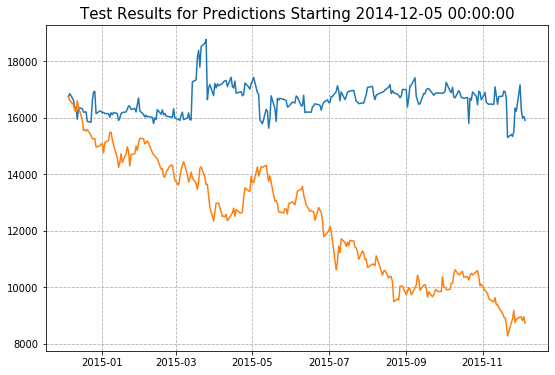

MAE for this test period: 4280.10513183462


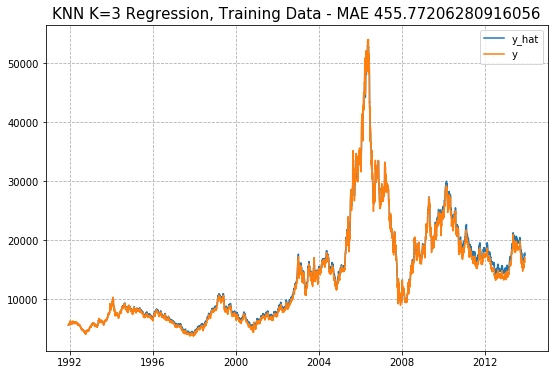

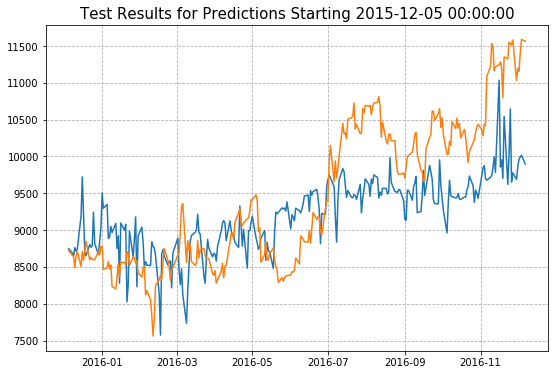

MAE for this test period: 603.9279526850902


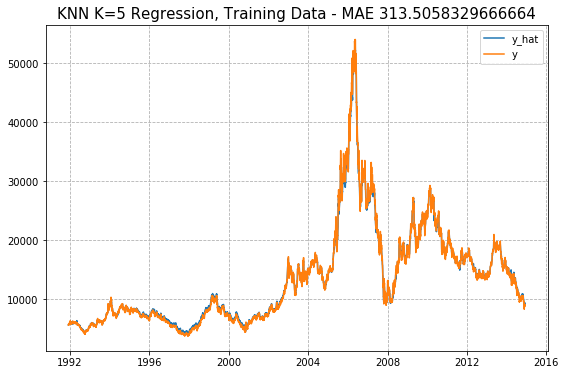

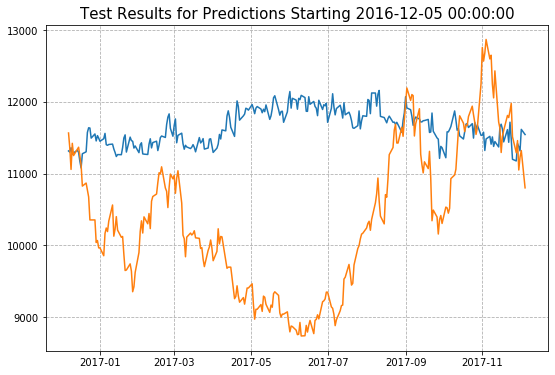

MAE for this test period: 1401.9212927521662


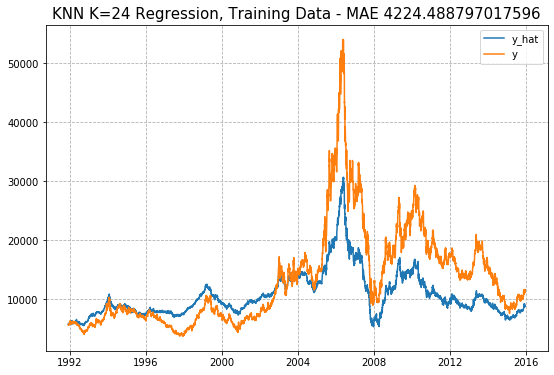

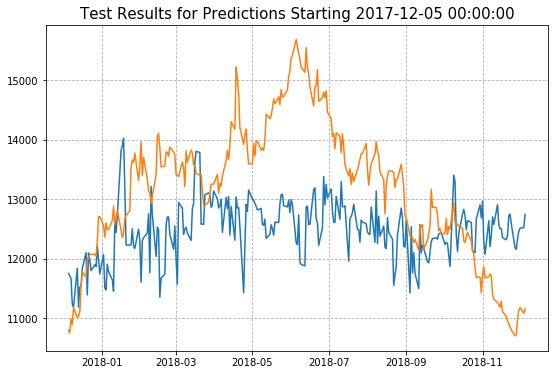

MAE for this test period: 1064.7804298778167


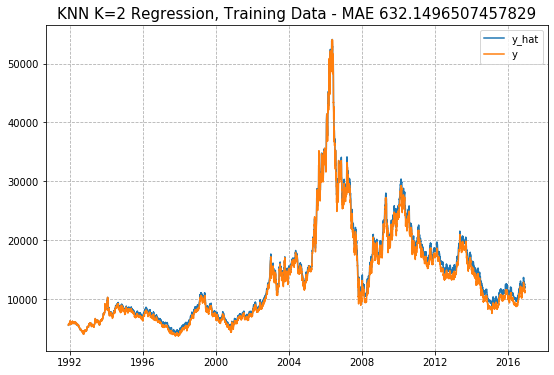

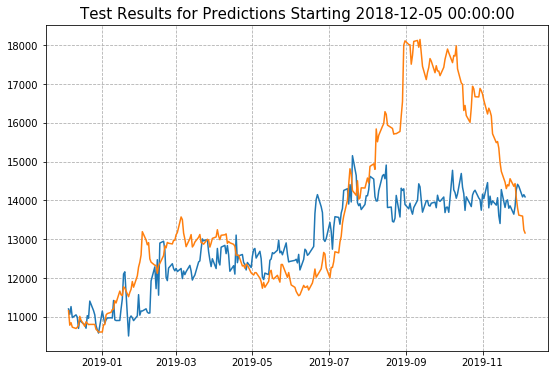

MAE for this test period: 1197.2539229917957


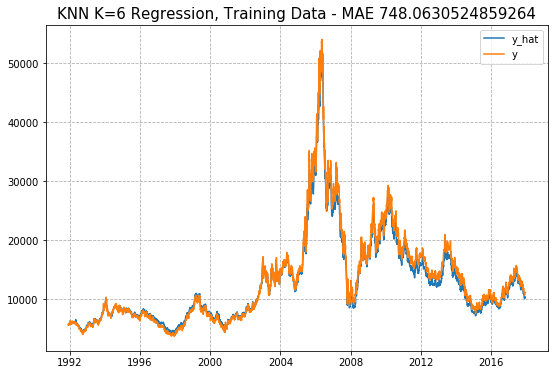

In [127]:
import datetime
# Input date refers to END of TESTING PERIOD!!!

for i,item in enumerate([datetime.datetime(2013, 12, 5), datetime.datetime(2014, 12, 5), datetime.datetime(2015, 12, 5), datetime.datetime(2016, 12, 5), datetime.datetime(2017, 12, 5)]):
    '''Organize/transforms the data'''
    train, test = try_out_model(item, df)
    X_train, X_test, y_train, y_test = preprocess_sets(train, test)
    '''Selects a K by looking at data fit over 15 years but starting ONE YEAR BEFORE current training data'''

    cv_results={}
    
    # Identifies optimal K value
    best_k = k_optimizer(item-pd.tseries.offsets.BusinessDay(n=261), df)
    #print('best_k: ', best_k)
    K = int(best_k)
    
    # Run the model
    regressor = neighbors.KNeighborsRegressor(n_neighbors=K)
    regressor.fit(X_train, y_train)
   
    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item2 in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item2+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index

    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]


    for key, item2 in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item2+rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index

    #mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    #cv_results[str(K)] = mae

    results = unscaled.copy()
    results.index = results.index + pd.DateOffset(years=1)


    unscaled_results = unscaled.copy()
    unscaled_results.index = unscaled_results.index + pd.DateOffset(years=1)
    original_y_results = original_y.copy()
    original_y_results.index = original_y_results.index + pd.DateOffset(years=1)


    plt.plot(unscaled_results)
    plt.plot(original_y_results)

    plt.grid(linestyle='dashed')
    plt.title('Test Results for Predictions Starting ' + str(item + pd.DateOffset(years=1)), fontsize=15)
    plt.show()

    mae = metrics.mean_absolute_error(original_y_results, unscaled_results)
    print('MAE for this test period:', mae)


    # FIT ON TRAINING DATA 

    y_pred_train  = regressor.predict(X_train)
    y_pred_train = pd.Series(y_pred_train)
    y_pred_train.index = y_train.index


    original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]
    original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
    original_y_train.index = y_train[window_setting:].index

    y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
    y_pred_train_unscaled.index = y_train[window_setting:].index



    plt.plot(y_pred_train_unscaled)
    plt.plot(original_y_train)
    plt.legend(['y_hat', 'y'])
    plt.grid(linestyle='dashed')
    plt.title('KNN K=' +str(K)+' Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
    
    #plt.savefig(filename)
    plt.show()
    
    
    # Save results
    save_train_preds = pd.DataFrame({'predicted_y_train':y_pred_train_unscaled, 'actual_y_train': original_y_train})
    save_test_preds = pd.DataFrame({'predicted_y_test':unscaled_results, 'actual_y_test': original_y_results})
    
    filename_train = 'results/backtesting_results/'+str(time_of_search)+'_train_start_'+str(y_pred_train_unscaled.index[0].date()) + '.csv'
    filename_test = 'results/backtesting_results/'+str(time_of_search)+'_test_start_'+str(unscaled_results.index[0].date())+'.csv'
    
    save_train_preds.to_sql('train_preds_'+str(i), con=engine, if_exists='replace', index = True)
    save_test_preds.to_sql('test_preds_'+str(i), con=engine, if_exists='replace', index = True)
    
    save_train_preds.to_csv(filename_train)
    save_test_preds.to_csv(filename_test)
    
    

## Final Model

In [100]:
test = df[df['y'].isna() == True]
today = test.index[0]-pd.tseries.offsets.BusinessDay(n=1)

In [114]:
#import datetime
# Set up of train set - FINAL PREDICTIONS

# Set up of test set - Separate all values with the dates associated with NaN y values
test = df[df['y'].isna() == True]
test.head()

# For now, pretend like the "current day" is 2019-01-01
today = datetime.datetime(2019, 12, 7)

# extract 16-1 years back
train_offset = pd.tseries.offsets.BusinessDay(n= 16*261)
start_date = today-train_offset
end_date = test.index[0]-pd.tseries.offsets.BusinessDay(n=1)


print('Start Date of Training', start_date)
print('End Date of Training',end_date)

#start_date_test = df[df['y'].isna() == True].index[0]
#test_offset = pd.tseries.offsets.BusinessDay(n=261)
#end_date_test = start_date_test+test_offset

train = df.loc[start_date:end_date, :]    
train

Start Date of Training 2003-12-05 00:00:00
End Date of Training 2018-12-07 00:00:00


,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,y
ds,,,,,,,,,,,,,,,,,,,
2003-12-05,591.9500,649.275,685.550,141.425,194.6250,217.82,-377.3750,298.6750,-104.625,-558.350,182.800,132.7125,-166.2250,-52.95,33.850,248.9000,203.850,130.0500,-1123.125
2003-12-08,688.1000,327.000,985.025,161.350,311.3000,94.42,-624.7250,268.2250,-95.925,-596.000,349.100,325.1875,-240.3125,-134.15,-39.000,47.0500,102.800,389.2500,-938.125
2003-12-09,922.1000,637.000,617.475,122.050,640.8500,154.47,-532.9750,439.1750,32.225,-504.750,288.200,82.8250,-143.2875,105.15,75.150,147.8250,52.750,298.3000,-1228.475
2003-12-10,922.1000,765.650,578.775,246.000,479.0000,109.82,-480.4250,442.6750,60.375,-453.800,191.100,263.0750,-55.3375,331.65,103.750,3.9000,-93.450,282.5500,-1421.100
2003-12-11,718.0000,577.200,490.375,370.150,411.3500,294.47,-423.0250,657.1750,204.425,-409.700,158.450,106.2750,-81.6875,414.60,196.600,-55.4750,-78.350,415.2000,-1148.550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-03,-5.2375,-543.325,-34.025,-745.950,-132.4875,-872.90,-227.3375,560.7625,525.850,-620.375,322.050,1021.4625,-509.7750,131.75,296.850,22.4125,-576.200,469.5750,-1370.000
2018-12-04,-79.4375,-478.325,394.900,-870.900,-253.6625,-985.40,-567.0375,655.2625,176.150,-527.075,234.850,509.4625,-951.8000,220.90,145.725,-141.6375,-487.375,334.5500,-1593.250
2018-12-05,27.0125,-372.650,26.375,-411.125,-824.9125,-800.75,-232.2375,485.3125,289.900,-351.600,156.825,714.1875,-913.9000,347.60,525.450,69.0125,-545.500,331.2000,-1516.250


In [115]:
test

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,y
ds,,,,,,,,,,,,,,,,,,,
2018-12-10,-296.0625,-649.450,-50.175,-709.625,-60.8375,-780.0750,-520.2125,514.2125,-328.1000,-131.0250,-189.350,685.9875,-270.0500,1061.800,892.9500,97.3625,-213.8750,299.9250,NaN
2018-12-11,-299.5375,-646.225,-87.000,-489.225,-71.0875,-514.8250,-457.8125,577.1625,-341.3500,40.7750,73.450,265.0625,-374.7750,926.725,916.0750,339.6875,-135.8250,-183.2375,NaN
2018-12-12,-240.7375,-616.025,-315.200,-323.625,-101.8625,-376.5500,-351.3625,737.8250,-11.5125,-267.8750,-32.075,18.9125,-309.2750,778.575,1088.6500,345.6625,-399.2375,-644.4375,NaN
2018-12-13,-162.0875,-610.100,-331.625,-151.500,-340.1375,-215.2000,-433.7375,772.2750,-263.8125,-73.1500,-372.575,-23.1125,-219.0500,854.275,1090.5500,356.4875,-554.0750,-679.3875,NaN
2018-12-14,87.0125,-450.925,-222.375,506.825,-175.6625,-70.6250,-296.7875,923.6500,-37.4375,-128.6000,222.475,-221.6875,213.1750,812.025,747.4750,429.0625,-363.6000,-924.3625,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-03,-1370.0000,-670.750,-37.175,1464.325,1279.3000,1518.9625,-8.7250,-15.5750,-621.5375,-40.8125,295.575,685.4500,-79.4375,394.900,-253.6625,-567.0375,176.1500,234.8500,NaN
2019-12-04,-1593.2500,-454.500,176.475,1177.625,1252.8000,1827.3125,151.1250,-92.0750,-568.7125,-64.6875,348.925,839.9750,27.0125,26.375,-824.9125,-232.2375,289.9000,156.8250,NaN
2019-12-05,-1516.2500,-466.500,172.075,1280.175,1481.6000,2105.4125,357.8000,-162.2250,-611.2125,-245.9375,311.900,890.9750,-319.1125,20.825,-310.1375,-235.2875,335.1750,-183.8750,NaN


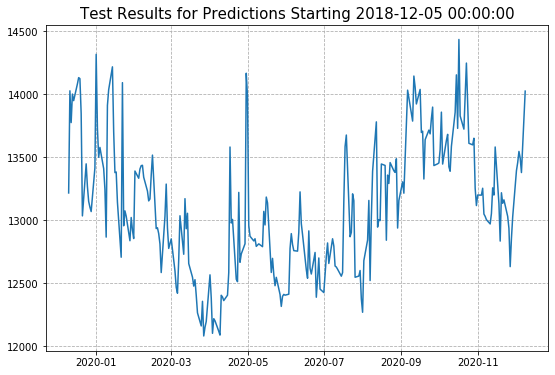

"\ny_pred_train  = regressor.predict(X_train)\ny_pred_train = pd.Series(y_pred_train)\ny_pred_train.index = y_train.index\n\n\noriginal_tail_train = LME_shifted.loc[y_train.index[:window_setting]]\noriginal_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)\noriginal_y_train.index = y_train[window_setting:].index\n\ny_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)\ny_pred_train_unscaled.index = y_train[window_setting:].index\n\nplt.plot(y_pred_train_unscaled)\nplt.plot(original_y_train)\nplt.legend(['y_hat', 'y'])\nplt.grid(linestyle='dashed')\nplt.title('KNN K=' +str(K)+' Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)\n\nplt.show()\n\n\n# Save results\nsave_train_preds = pd.DataFrame({'predicted_y_train':y_pred_train_unscaled, 'actual_y_train': original_y_train})\nsave_test_preds = pd.DataFrame({'predicted_y_test':unscal

In [116]:
# FINAL MODEL 
#import datetime
# Input date refers to END of TESTING PERIOD!!!

from datetime import datetime


'''Organize/transforms the data'''
#item =  datetime(2018, 10, 8) 
#train, test = try_out_model(item, df)
X_train, X_test, y_train, y_test = preprocess_sets(train, test)
'''Selects a K by looking at data fit over 15 years but starting ONE YEAR BEFORE current training data'''

cv_results={}

# Identifies optimal K value
best_k = k_optimizer(item-pd.tseries.offsets.BusinessDay(n=261), df)
K = int(best_k)
#K=7

# Run the model3
regressor = neighbors.KNeighborsRegressor(n_neighbors=K)
regressor.fit(X_train, y_train)



y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item2 in y_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item2+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))



unscaled = pd.Series(original_tail)
unscaled = unscaled[window_setting:]
unscaled.index = y_test.index

'''
original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item2 in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item2+rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index
'''

#mae = metrics.mean_absolute_error(original_y, unscaled)

#print('kfold test accuracy =', kfold_test_accuracy)
#cv_results[str(K)] = mae

unscaled_results = unscaled.copy()
unscaled_results.index = unscaled_results.index + pd.DateOffset(years=1)
# Shift original y_test forward again

'''
original_y_results = original_y.copy()
original_y_results.index = original_y_results.index + pd.DateOffset(years=1)
plt.plot(original_y_results)
'''

plt.plot(unscaled_results)


plt.grid(linestyle='dashed')
plt.title('Test Results for Predictions Starting ' + str(item + pd.DateOffset(years=1)), fontsize=15)
plt.show()

'''
mae = metrics.mean_absolute_error(original_y_results, unscaled_results)
print('MAE for this test period:', mae)
'''

# FIT ON TRAINING DATA 
'''
y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index


original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]
original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.grid(linestyle='dashed')
plt.title('KNN K=' +str(K)+' Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)

plt.show()


# Save results
save_train_preds = pd.DataFrame({'predicted_y_train':y_pred_train_unscaled, 'actual_y_train': original_y_train})
save_test_preds = pd.DataFrame({'predicted_y_test':unscaled_results, 'actual_y_test': original_y_results})

filename_train = 'results/backtesting_results/'+str(time_of_search)+'_train_start_'+str(y_pred_train_unscaled.index[0].date()) + '.csv'
filename_test = 'results/backtesting_results/'+str(time_of_search)+'_test_start_'+str(unscaled_results.index[0].date())+'.csv'



'''



#save_train_preds.to_sql('train_preds_'+str(i), con=engine, if_exists='replace', index = True)
#save_test_preds.to_sql('test_preds_'+str(i), con=engine, if_exists='replace', index = True)


    

In [132]:
#import pickle 

#filename = 'results/Forecasts/finalized_model_' + str(timestamp.date()) + '.pickle'

#pickle.dump(regressor, open(filename, 'wb'))

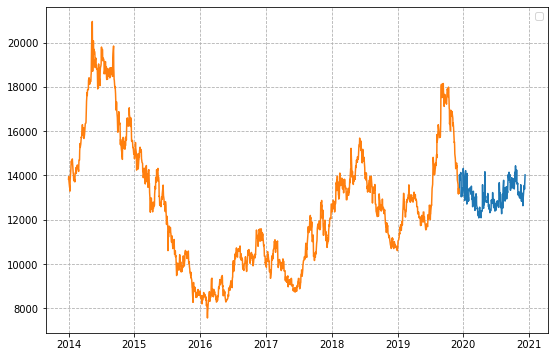

In [120]:
plt.plot(unscaled_results)
#plt.plot(LME)
plt.plot(LME[LME.index.year>2013])
plt.legend()
plt.grid(linestyle='dashed')
plt.show()

In [157]:
print(LME.tail())
print(results.head())


Unnamed: 1
2019-10-01    17434.0
2019-10-02    17640.0
2019-10-03    17775.0
2019-10-04    17906.0
2019-10-07    17810.0
Freq: B, Name: Cash Price ($/MT), dtype: float64
ds
2019-10-09    12868.053571
2019-10-10    12894.941250
2019-10-11    13025.587598
2019-10-12    12614.325192
2019-10-13    12736.512881
dtype: float64


In [121]:
# TO save a forecasted results file
from datetime import datetime
now = datetime.now()

timestamp = datetime.timestamp(now)
timestamp = datetime.fromtimestamp(timestamp)

# To save as a csv data type
#results.to_csv('forecasts_'+str(timestamp)[:10] + '.csv', header=True)

print(str(timestamp.date()))

2019-12-10


In [122]:
# SAVE PREDICTION RESULTS TO SQL AND CSV
results_df = pd.DataFrame({'Actual Price': LME, 'Predicted Price': unscaled_results})
results_df

results_df.to_csv('results/Forecasts/forecasts_'+str(timestamp)[:10] + '.csv', header=True)
#results_df.to_sql('forecasts_main' , con=engine, if_exists='replace', index = True)



In [123]:
df_upload = pd.read_sql_query('SELECT * from forecasts_main;', connection)

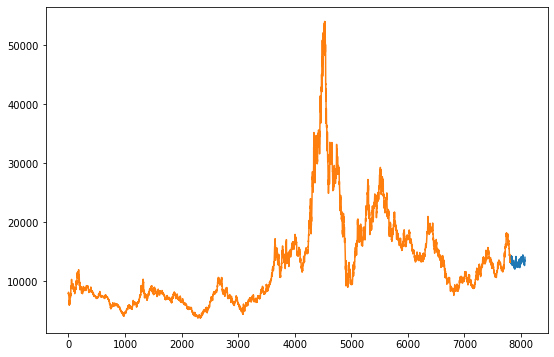

In [125]:
plt.plot(df_upload['Predicted Price'])
plt.plot(df_upload['Actual Price'])

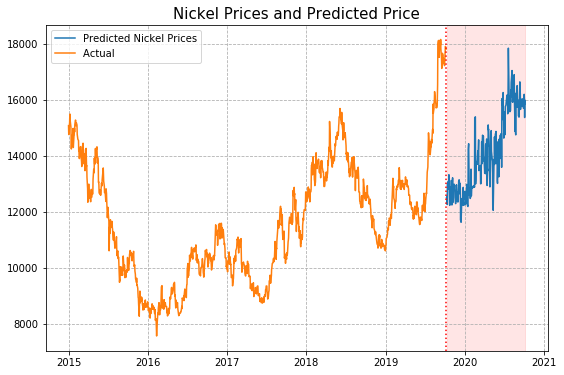

In [140]:
plt.plot(results)
plt.plot(LME[LME.index.year > 2014])

#plt.plot(LME)


plt.grid(linestyle='dashed')
plt.legend(['Predicted Nickel Prices', 'Actual '])
plt.axvspan(results.index[0], results.index[-1], alpha=0.1, color='red')
plt.title('Nickel Prices and Predicted Price', fontsize=15)

plt.axvline(datetime(2019, 10, 8), color='r', linestyle='dotted')


plt.show()


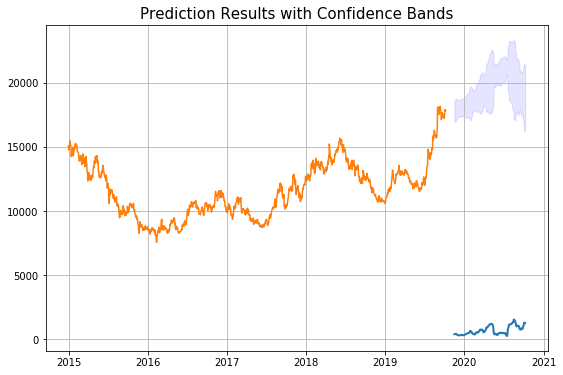

In [149]:
time_series_df = pd.DataFrame(results)
smooth_path    = time_series_df.rolling(30).mean()
path_deviation = 2 * time_series_df.rolling(30).std()
plt.plot(path_deviation, linewidth=2)
plt.fill_between(path_deviation.index, (smooth_path-2*path_deviation)[0], (smooth_path+2*path_deviation)[0], color='b', alpha=.1)
plt.grid()
plt.title('Prediction Results with Confidence Bands', fontsize=15)
plt.plot(LME[LME.index.year > 2014])

plt.show()

## Next Task: Create Visualizations for Predicted and previous values 

In [59]:
y_pred = unscaled

print(y_pred)


#y_lower = np.percentile(y_pred, 10)

#print(y_lower)
#y_higher = np.percentile(y_Pred, 90)
#y_mid = np.percentile(y_pred, 50)

ds
2018-10-08    17534.786229
2018-10-09    17541.409862
2018-10-10    17574.645398
2018-10-11    17494.281269
2018-10-12    17537.562706
2018-10-15    17564.122197
2018-10-16    17631.015595
2018-10-17    17674.201332
2018-10-18    17852.590636
2018-10-19    17178.460634
2018-10-22    17834.034937
2018-10-23    17630.692828
2018-10-24    17422.425986
2018-10-25    17090.162540
2018-10-26    17004.528506
2018-10-29    17256.064889
2018-10-30    17714.567286
2018-10-31    17555.436540
2018-11-01    17812.865570
2018-11-02    17492.100374
2018-11-05    17350.381452
2018-11-06    16930.917569
2018-11-07    17245.440200
2018-11-08    17396.596678
2018-11-09    17844.675796
2018-11-12    17497.611747
2018-11-13    17850.273936
2018-11-14    17684.969904
2018-11-15    18285.868714
2018-11-16    18150.118847
                  ...     
2019-08-27    18386.798281
2019-08-28    18548.640353
2019-08-29    18242.916031
2019-08-30    17652.135329
2019-09-02    17949.180479
2019-09-03    17876.24239

In [39]:
# Confidence Interval Time Series From tutorial https://campus.datacamp.com/courses/machine-learning-for-time-series-data-in-python/validating-and-inspecting-time-series-models?ex=12

# Bootstrapping TUtorial Statistics
# https://campus.datacamp.com/courses/statistical-thinking-in-python-part-2/bootstrap-confidence-intervals?ex=5

n_boots = 100

bootstrap_means = np.zeros((n_boots, len(y_pred)))

for ii in range(n_boots):
    # Generate random indices for our data with replacement,
    # then take the sample mean
    random_sample = resample(y_pred)
    bootstrap_means[ii] = random_sample.mean(axis=0)
# Compute the percentiles of choice for the bootstrapped means
percentiles = np.percentile(bootstrap_means, (2.5, 97.5), axis=0)

#conf_int = pd.DataFrame({'2.5%': bootstrap_interval(y_pred)[0], '97.5%': bootstrap_interval(y_pred)[1], 'actual': y_pred})
conf_int = pd.DataFrame({'2.5%': bootstrap_interval(y_pred)[0], '97.5%': bootstrap_interval(y_pred)[1], 'actual': y_pred})


In [44]:
print(bootstrap_means)

[[18456.84378109 18456.84378109 18456.84378109 ... 18456.84378109
  18456.84378109 18456.84378109]
 [18461.94082895 18461.94082895 18461.94082895 ... 18461.94082895
  18461.94082895 18461.94082895]
 [18590.67147797 18590.67147797 18590.67147797 ... 18590.67147797
  18590.67147797 18590.67147797]
 ...
 [18459.25407789 18459.25407789 18459.25407789 ... 18459.25407789
  18459.25407789 18459.25407789]
 [18529.62445989 18529.62445989 18529.62445989 ... 18529.62445989
  18529.62445989 18529.62445989]
 [18570.15957174 18570.15957174 18570.15957174 ... 18570.15957174
  18570.15957174 18570.15957174]]


In [37]:
n_boots = 100

bootstrap_means = np.zeros((n_boots, len(y_pred)))

for ii in range(n_boots):
    # Generate random indices for our data with replacement,
    # then take the sample mean
    random_sample = resample(y_pred)
    bootstrap_means[ii] = random_sample.mean(axis=0)
    print('random sample: ', random_sample)
    print()
    print('calculated mean', random_sample.mean(axis=0))
    print()

random sample:  ds
2018-11-28    17625.593422
2019-02-27    18356.570512
2019-01-29    18358.778301
2019-02-25    19034.772323
2018-12-31    18046.456536
2019-09-20    17549.608819
2018-12-13    18468.833320
2019-07-10    19789.626166
2018-11-29    18170.158469
2019-08-22    17548.826393
2019-05-30    19447.173936
2019-08-21    17887.554343
2019-09-09    18080.648368
2019-03-15    18480.482787
2018-10-11    17494.281269
2019-02-12    18403.477579
2019-02-11    18602.477223
2019-06-28    20132.671710
2018-12-06    18010.799320
2019-03-29    18336.212843
2019-05-02    19321.039420
2019-02-07    18691.143417
2019-06-06    19718.558893
2019-05-23    19395.219011
2019-09-23    17331.690037
2019-04-29    19082.124611
2019-01-25    18784.746840
2019-02-12    18403.477579
2019-02-26    18858.522699
2019-09-16    17538.842278
                  ...     
2019-06-05    19759.973145
2018-11-12    17497.611747
2019-04-17    19170.780500
2019-06-11    19867.582422
2019-09-24    17284.894348
2019-06-2


random sample:  ds
2019-07-12    19982.504484
2019-07-25    18394.101326
2019-04-12    18985.278629
2019-01-15    18497.854885
2019-03-26    18742.749200
2019-03-14    18378.962986
2019-02-19    18694.148427
2019-07-01    20287.408751
2019-07-09    19792.634979
2019-09-30    16413.433836
2019-09-13    17389.691705
2019-08-14    17528.843131
2019-08-16    17430.142103
2019-03-29    18336.212843
2018-12-03    18180.276105
2019-09-12    17660.225321
2018-10-10    17574.645398
2018-11-27    18371.351862
2019-01-29    18358.778301
2019-01-21    18563.399146
2019-07-08    20452.302151
2019-07-29    18847.099827
2019-05-13    19488.879305
2019-07-25    18394.101326
2019-01-04    18461.616093
2018-10-30    17714.567286
2019-04-15    18882.258251
2018-11-08    17396.596678
2018-12-04    18029.378041
2019-07-29    18847.099827
                  ...     
2019-06-04    19836.085132
2019-01-24    18755.643119
2019-09-10    17798.327390
2019-08-05    19115.069366
2018-10-23    17630.692828
2018-10-

In [35]:
bootstrap_means = np.zeros((n_boots, len(y_pred)))
bootstrap_means.shape

(100, 261)

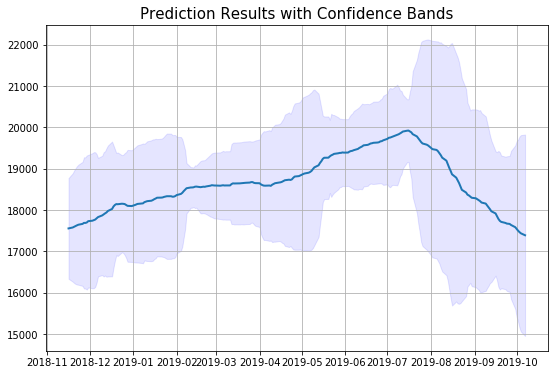

In [25]:
# From https://stackoverflow.com/questions/50161140/how-to-plot-a-time-series-array-with-confidence-intervals-displayed-in-python

time_series_df = pd.DataFrame(y_pred)
smooth_path    = time_series_df.rolling(30).mean()
path_deviation = 2 * time_series_df.rolling(30).std()
plt.plot(smooth_path, linewidth=2)
plt.fill_between(path_deviation.index, (smooth_path-2*path_deviation)[0], (smooth_path+2*path_deviation)[0], color='b', alpha=.1)
plt.grid()
plt.title('Prediction Results with Confidence Bands', fontsize=15)
plt.show()

In [44]:
for date in dates:
    print(date)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


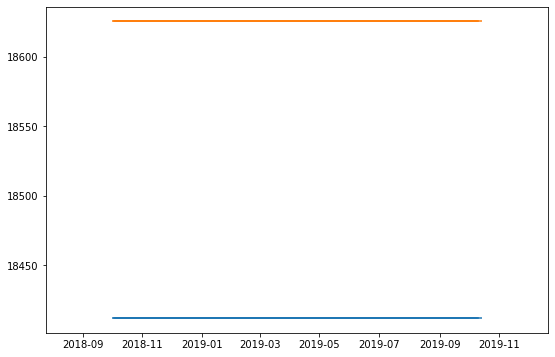

In [27]:
fig, ax = plt.subplots()
ax.scatter(y_pred.index, percentiles[0], marker='_', s=200)
ax.scatter(y_pred.index, percentiles[1], marker='_', s=200)

In [30]:
def my_corrcoef(est, X, y):
    """Return the correlation coefficient
    between model predictions and a validation set."""
    return np.corrcoef(y, est.predict(X))[1, 0]
# Grab the date of the first index of each validation set
first_indices = [data.index[tt[0]] for tr, tt in cv.split(X, y)]
# Calculate the CV scores and convert to a Pandas Series
cv_scores = cross_val_score(model, X, y, cv=cv, scoring=my_corrcoef)
cv_scores = pd.Series(cv_scores, index=first_indices)



fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
# Calculate a rolling mean of scores over time
cv_scores_mean = cv_scores.rolling(10, min_periods=1).mean()
cv_scores.plot(ax=axs[0])
axs[0].set(title='Validation scores (correlation)', ylim=[0, 1])
# Plot the raw data
data.plot(ax=axs[1])
axs[1].set(title='Validation data')

NameError: name 'cv' is not defined

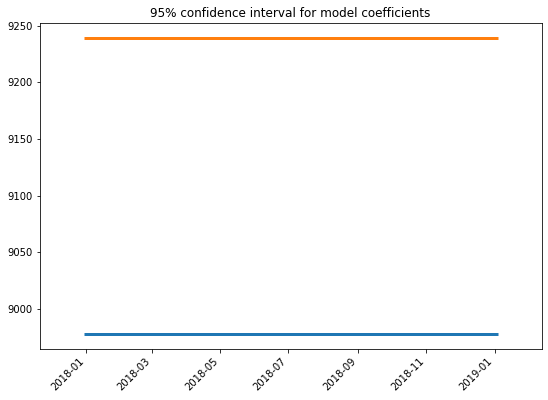

In [93]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(y_pred)

# Plot it
fig, ax = plt.subplots()
ax.scatter(y_pred.index, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(y_pred.index, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
# bootstrap for mean
boot_means = []
for _ in range(100):
    bootsample = np.random.choice(sample,size=30, replace=True)
    boot_means.append(bootsample.mean())